In [1]:
%matplotlib inline

2. Test with PSPNet Pre-trained Models
======================================

This is a quick demo of using GluonCV PSPNet model on ADE20K dataset.
Please follow the `installation guide <../index.html>`_ to install MXNet and GluonCV if not yet.


In [2]:
import mxnet as mx
from mxnet import image
from mxnet.gluon.data.vision import transforms
import gluoncv
import pandas as pd
import numpy as np
import os
from tqdm import tqdm_notebook as tqdm
# using gpu
ctx = mx.gpu(1)

Prepare the image
-----------------

download the example image



In [3]:
filename = "../input/test/52c49cd9fee4319b.jpg"

load the image



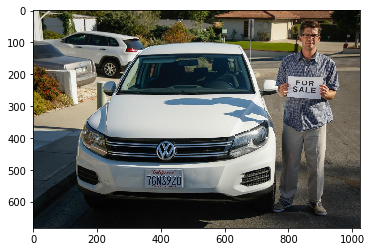

In [4]:
img = image.imread(filename)

from matplotlib import pyplot as plt
plt.imshow(img.asnumpy())
plt.show()

normalize the image using dataset mean



In [5]:
from gluoncv.data.transforms.presets.segmentation import test_transform
img = test_transform(img, ctx)

Load the pre-trained model and make prediction
----------------------------------------------

get pre-trained model



In [6]:
#model = gluoncv.model_zoo.get_model('psp_resnet101_ade', pretrained=True, ctx=ctx)
model = gluoncv.model_zoo.get_model('deeplab_resnet101_ade', pretrained=True, ctx=ctx)

make prediction using single scale



In [7]:
output = model.predict(img)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

Add color pallete for visualization



In [8]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))
from gluoncv.utils.viz import get_color_pallete
import matplotlib.image as mpimg
mask = get_color_pallete(predict, 'ade20k')

In [9]:
output = output.asnumpy()
output.shape

(1, 150, 682, 1024)

show the predicted mask



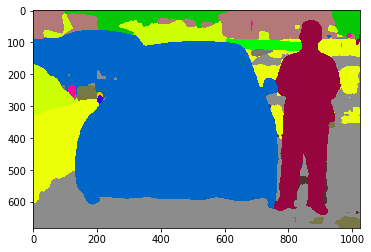

In [10]:
mmask = mpimg.imread('output.png')
plt.imshow(mmask)
plt.show()

In [11]:
ADE20K_INSTANCE_CATEGORY_NAMES = ['wall','building','sky','floor','tree','ceiling','road','bed','windowpane',
'grass','cabinet','sidewalk','person','earth','door','table','mountain','plant','curtain','chair','car','water',
'painting','sofa','shelf','house','sea','mirror','rug','field','armchair','seat','fence','desk','rock','wardrobe',
'lamp','bathtub','railing','cushion','base','box','column','signboard','chest of drawers','counter','sand','sink',
'skyscraper','fireplace','refrigerator','grandstand','path','stairs','runway','case','pool table','pillow',
'screen door','stairway','river','bridge','bookcase','blind','coffee table','toilet','flower','book','hill','bench',
'countertop','stove','palm','kitchen island','computer','swivel chair','boat','bar','arcade machine','hovel','bus',
'towel','light','truck','tower','chandelier','awning','streetlight','booth','television receiver','airplane',
'dirt track','apparel','pole','land','bannister','escalator','ottoman','bottle','buffet','poster','stage','van',
'ship','fountain','conveyer belt','canopy','washer','plaything','swimming pool','stool','barrel','basket',
'waterfall','tent','bag','minibike','cradle','oven','ball','food','step','tank','trade name','microwave','pot',
'animal','bicycle','lake','dishwasher','screen','blanket','sculpture','hood','sconce','vase','traffic light','tray',
'ashcan','fan','pier','crt screen','plate','monitor','bulletin board','shower','radiator','glass','clock','flag']
ade_names = ADE20K_INSTANCE_CATEGORY_NAMES

In [12]:
ade_names.index("car")

20

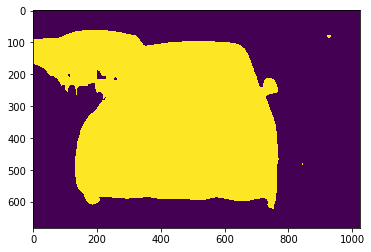

In [13]:
car_index = ade_names.index("car")
car_mask = (output[0,:,:,:].argmax(axis=0) == car_index)
plt.imshow(car_mask)

In [14]:
sigmoid(output[0,car_index,:,:][car_mask].mean())

0.9999955936581028

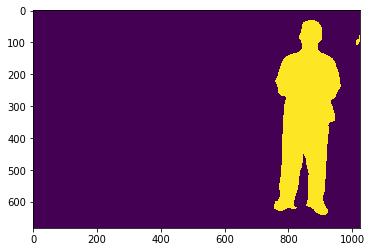

In [15]:
person_index = ade_names.index("person")
person_mask = (output[0,:,:,:].argmax(axis=0) == person_index)
plt.imshow(person_mask)

In [16]:
sigmoid(output[0,person_index,:,:][person_mask].mean())

0.9999898954131496

In [17]:
IMAGE_DIR = "/home/nama/Documents/Kaggle/OpenImage2019_Seg/input/test/"

In [18]:
class_lookup_df = pd.read_csv("./challenge-2019-classes-description-segmentable.csv", header=None)
empty_submission_df = pd.read_csv("../input/sample_empty_submission.csv")

In [19]:
class_lookup_df.columns = ["encoded_label","label"]
class_lookup_df['label'] = class_lookup_df['label'].str.lower()
class_lookup_df.head()

,encoded_label,label
0,/m/01bms0,screwdriver
1,/m/03jbxj,light switch
2,/m/0jy4k,doughnut
3,/m/09gtd,toilet paper
4,/m/01j5ks,wrench


In [20]:
empty_submission_df.head()

,ImageID,ImageWidth,ImageHeight,PredictionString
0,80155d58d0ee19bd,-1,-1,NaN
1,52a76f3fe21185bf,-1,-1,NaN
2,65e9da7c04c8e4cd,-1,-1,NaN
3,6d10fa21d93bd6cc,-1,-1,NaN
4,0841dee573a875ca,-1,-1,NaN


See:
https://www.kaggle.com/c/open-images-2019-instance-segmentation/overview/evaluation

In [21]:
import base64
import numpy as np
from pycocotools import _mask as coco_mask
import typing as t
import zlib

def encode_binary_mask(mask: np.ndarray) -> t.Text:
    """Converts a binary mask into OID challenge encoding ascii text."""

    # check input mask --
    if mask.dtype != np.bool:
        raise ValueError("encode_binary_mask expects a binary mask, received dtype == %s" % mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError("encode_binary_mask expects a 2d mask, received shape == %s" % mask.shape)

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str

In [ ]:
ImageID_list = []
ImageWidth_list = []
ImageHeight_list = []
PredictionString_list = []

for num, row in tqdm(empty_submission_df.iterrows(), total=len(empty_submission_df)):
    filename = row["ImageID"] + ".jpg"
    img = image.imread(os.path.join(IMAGE_DIR, filename))
    img = test_transform(img, ctx)
    output = model.predict(img).asnumpy()
    
    height = img.shape[2]
    width  = img.shape[3]
    img_out = output[0,:,:,:].argmax(axis=0)
        
    PredictionString = ""
        
    for i in range(150):        
        class_id = i
        confidence = 1.0
        
        labelname = ade_names[i]
        if class_lookup_df[class_lookup_df["label"] == labelname].shape[0] == 0:
            # no match label
            continue
            
        pred_mask = (img_out == i)
        if pred_mask.sum() == 0:
            continue
        confidence = sigmoid(output[0,i,:,:][pred_mask].mean())

        if confidence > 0.5:
            encoded_mask = encode_binary_mask(pred_mask)
            encoded_label = class_lookup_df[class_lookup_df["label"] == labelname]["encoded_label"].item()

            PredictionString += encoded_label 
            PredictionString += " "
            PredictionString += str(confidence)
            PredictionString += " "
            PredictionString += encoded_mask.decode()
            PredictionString += " "
        
    ImageID_list.append(row["ImageID"])
    ImageWidth_list.append(width)
    ImageHeight_list.append(height)
    PredictionString_list.append(PredictionString)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: FutureWarning: `item` has been deprecated and will be removed in a future version


In [ ]:
results=pd.DataFrame({"ImageID":ImageID_list,
                      "ImageWidth":ImageWidth_list,
                      "ImageHeight":ImageHeight_list,
                      "PredictionString":PredictionString_list
                     })

In [ ]:
results.head()

In [ ]:
results.to_csv("submission002.csv", index=False)